In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
# Engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

Station = Base.classes.station
Measurement = Base.classes.measurement


C:\Users\52614\AppData\Local\Temp\ipykernel_20408\2237761667.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(class_name)


measurement
station


In [9]:
# Save references to each table
# Query and print all station names
session = Session(bind=engine)  # Ensure you have created a session as shown previously
stations = session.query(Station).all()
for station in stations:
    print(station.name)


WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


In [10]:
# Create our session (link) from Python to the DB
# Import the sessionmaker module from SQLAlchemy
from sqlalchemy.orm import sessionmaker

#session
Session = sessionmaker(bind=engine)
session = Session()


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
# Import the func module for SQL functions
from sqlalchemy import func

# Query to find the most recent date in the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).one()
print("Most Recent Date:", most_recent_date[0])


Most Recent Date: 2017-08-23


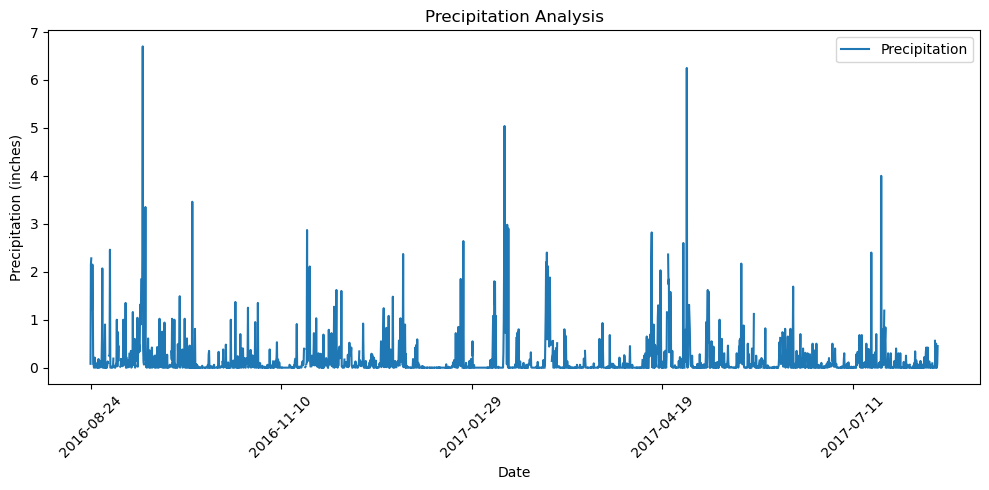

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sqlalchemy import func

# `most_recent_date` is retrieved as a string 'YYYY-MM-DD'
most_recent_date = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = last_date - timedelta(days=365)

# Query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sorts the dataframe by date
df.sort_index(inplace=True)

# Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation Analysis", figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend(['Precipitation'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
summary_statistics



count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [20]:

# Query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations:", total_stations)


Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

#Results
for station, count in most_active_stations:
    print(f"Station {station} has {count} records")


Station USC00519281 has 2772 records
Station USC00519397 has 2724 records
Station USC00513117 has 2709 records
Station USC00519523 has 2669 records
Station USC00516128 has 2612 records
Station USC00514830 has 2202 records
Station USC00511918 has 1979 records
Station USC00517948 has 1372 records
Station USC00518838 has 511 records


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# most_active_station_id is stored in this variable from previous query
most_active_station_id = most_active_stations[0][0]

# Query to find the lowest, highest, and average temperature of the most active station
temperature_stats = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).filter(Measurement.station == most_active_station_id).one()

#Results 
min_temp, max_temp, avg_temp = temperature_stats

print(f"Lowest Temperature: {min_temp} F")
print(f"Highest Temperature: {max_temp} F")
print(f"Average Temperature: {avg_temp:.2f} F")


Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66 F


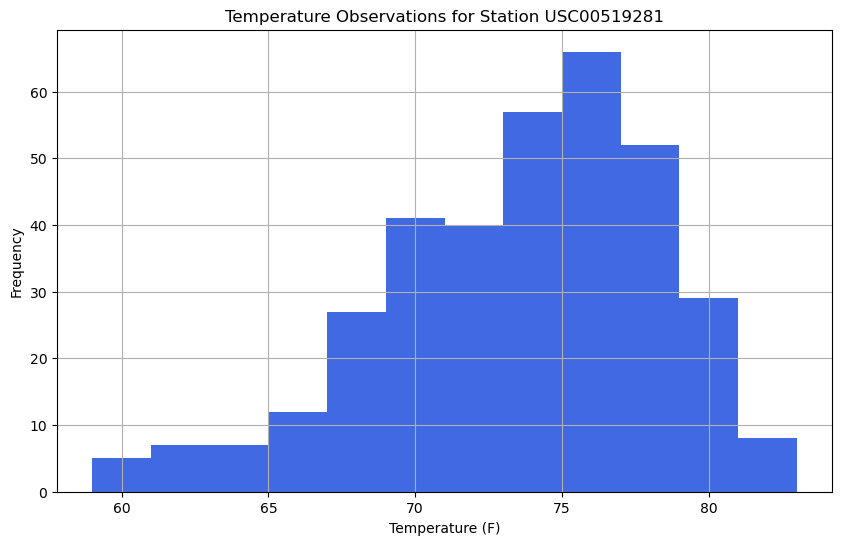

In [18]:
# Using the most active station id
# Last 12 months of temperature observation data for this station 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#  most_recent_date is already available and in 'YYYY-MM-DD' format
most_recent_date = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = last_date - timedelta(days=365)

#Last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).all()

# Extracts the temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plots the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='royalblue')
plt.title('Temperature Observations for Station ' + most_active_station_id)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Close Session

In [19]:
# Close Session
session.close()